In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [37]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [149]:
class_num = 2

In [150]:
X_tr = np.loadtxt("../data/features_cnn/X_tr.txt")
X_te = np.loadtxt("../data/features_cnn/X_te.txt")

y_tr = np.loadtxt("../data/features_cnn/Y_tr.txt", dtype=int)
y_te = np.loadtxt("../data/features_cnn/Y_te.txt", dtype=int)


KeyboardInterrupt: 

In [192]:


X_tr2 = X_tr[(y_tr==0) | (y_tr==2) | (y_tr==5) | (y_tr==8)]
y_tr2 = y_tr[(y_tr==0) | (y_tr==2) | (y_tr==5) | (y_tr==8)]
X_te2 = X_te[(y_te==0) | (y_te==2) | (y_te==5) | (y_te==8)]
y_te2 = y_te[(y_te==0) | (y_te==2) | (y_te==5) | (y_te==8)]

y_tr2[(y_tr2==2)] = 0
y_tr2[(y_tr2==5) | (y_tr2==8)] = 1

y_te2[(y_te2==2)] = 0
y_te2[(y_te2==5) | (y_te2==8)] = 1

In [193]:
def get_arr(y):
    y_arr = np.zeros((y.shape[0], class_num))
    for i in range(y.shape[0]):
        val = y[i]
        arr = np.zeros((class_num))
        arr[val] = 1
        y_arr[i,:] = arr
    return y_arr

In [153]:
y_tr_arr = get_arr(y_tr)
y_te_arr = get_arr(y_te)

IndexError: index 6 is out of bounds for axis 0 with size 2

In [194]:
y_tr_arr2 = get_arr(y_tr2)
y_te_arr2 = get_arr(y_te2)

In [195]:
print(y_tr_arr.shape)
print(y_te_arr.shape)

print(y_tr_arr2.shape)
print(y_te_arr2.shape)

(4105, 9)
(1760, 9)
(2068, 2)
(911, 2)


In [196]:
print(y_tr_arr[0])
print(y_tr[0])
print(y_te_arr[0])
print(y_te[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
6


In [201]:
print(X_tr2.shape)
print(X_te2.shape)
print(y_tr2.shape)
print(y_tr2[(y_tr2==0)].shape)

(2068, 100, 100, 3)
(911, 100, 100, 3)
(2068,)
(495,)


In [202]:
X_tr = np.reshape(X_tr, (-1, 100, 100, 3))
X_te = np.reshape(X_te, (-1, 100, 100, 3))

In [42]:
print(X_tr.shape)
print(X_te.shape)

(4105, 100, 100, 3)
(1760, 100, 100, 3)


In [44]:
print(y_tr.shape)
print(y_te.shape)

(4105,)
(1760,)


In [203]:
# We know that  images are 100 pixels in each dimension.
img_size = 100

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 2

In [204]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [158]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [159]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [160]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [161]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [51]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [162]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [163]:
y_true_cls = tf.argmax(y_true, axis=1)

In [164]:
# Convolutional Layer 1

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [165]:
layer_conv1

<tf.Tensor 'Relu_6:0' shape=(?, 50, 50, 16) dtype=float32>

In [166]:
#  Convolutional Layer 2

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [168]:
layer_conv2

<tf.Tensor 'Relu_7:0' shape=(?, 25, 25, 36) dtype=float32>

In [169]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [170]:
layer_flat

<tf.Tensor 'Reshape_2:0' shape=(?, 22500) dtype=float32>

In [171]:
num_features

22500

In [172]:
# Fully-Connected Layer 1

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [173]:
layer_fc1

<tf.Tensor 'Relu_8:0' shape=(?, 128) dtype=float32>

In [174]:
# Fully-Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [175]:
layer_fc2

<tf.Tensor 'add_11:0' shape=(?, 2) dtype=float32>

In [176]:
y_pred = tf.nn.softmax(layer_fc2)

In [177]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [178]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)

In [179]:
cost = tf.reduce_mean(cross_entropy)

In [180]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [181]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [182]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [214]:
session = tf.Session()

In [215]:
session.run(tf.global_variables_initializer())

In [216]:
train_batch_size = 64

In [217]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]

    return data_shuffle, labels_shuffle

In [219]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    acc_total = 0
    count = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        x_batch, y_true_batch = next_batch(train_batch_size, X_tr2, y_tr_arr2)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        acc = session.run(accuracy, feed_dict=feed_dict_train)
        acc_total += acc
        count += 1
        # Print status every 10 iterations.
        if i % 50 == 0:
            # Calculate the accuracy on the training-set.
            
            acc_ave = acc_total / count
            acc_total = 0
            count = 0
            
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc_ave))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [226]:
# Split the test-set into smaller batches of this size.
test_batch_size = 128

def print_test_accuracy(show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = X_te2.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_te2[i:j, :]

        # Get the associated labels.
        labels = y_te_arr2[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_te2

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [221]:
print_test_accuracy()

Accuracy on Test-Set: 76.0% (692 / 911)


In [223]:
optimize(num_iterations=15000)

Optimization Iteration:      1, Training Accuracy:  85.9%
Optimization Iteration:     51, Training Accuracy:  85.2%
Optimization Iteration:    101, Training Accuracy:  87.2%
Optimization Iteration:    151, Training Accuracy:  86.1%
Optimization Iteration:    201, Training Accuracy:  86.7%
Optimization Iteration:    251, Training Accuracy:  88.2%
Optimization Iteration:    301, Training Accuracy:  89.0%
Optimization Iteration:    351, Training Accuracy:  91.0%
Optimization Iteration:    401, Training Accuracy:  89.3%
Optimization Iteration:    451, Training Accuracy:  91.9%
Optimization Iteration:    501, Training Accuracy:  93.1%
Optimization Iteration:    551, Training Accuracy:  92.1%
Optimization Iteration:    601, Training Accuracy:  93.0%
Optimization Iteration:    651, Training Accuracy:  92.5%
Optimization Iteration:    701, Training Accuracy:  92.4%
Optimization Iteration:    751, Training Accuracy:  93.3%
Optimization Iteration:    801, Training Accuracy:  93.6%
Optimization I

Optimization Iteration:   7101, Training Accuracy: 100.0%
Optimization Iteration:   7151, Training Accuracy: 100.0%
Optimization Iteration:   7201, Training Accuracy: 100.0%
Optimization Iteration:   7251, Training Accuracy: 100.0%
Optimization Iteration:   7301, Training Accuracy: 100.0%
Optimization Iteration:   7351, Training Accuracy: 100.0%
Optimization Iteration:   7401, Training Accuracy: 100.0%
Optimization Iteration:   7451, Training Accuracy: 100.0%
Optimization Iteration:   7501, Training Accuracy: 100.0%
Optimization Iteration:   7551, Training Accuracy: 100.0%
Optimization Iteration:   7601, Training Accuracy: 100.0%
Optimization Iteration:   7651, Training Accuracy: 100.0%
Optimization Iteration:   7701, Training Accuracy: 100.0%
Optimization Iteration:   7751, Training Accuracy: 100.0%
Optimization Iteration:   7801, Training Accuracy: 100.0%
Optimization Iteration:   7851, Training Accuracy: 100.0%
Optimization Iteration:   7901, Training Accuracy: 100.0%
Optimization I

Optimization Iteration:  14201, Training Accuracy: 100.0%
Optimization Iteration:  14251, Training Accuracy: 100.0%
Optimization Iteration:  14301, Training Accuracy: 100.0%
Optimization Iteration:  14351, Training Accuracy: 100.0%
Optimization Iteration:  14401, Training Accuracy: 100.0%
Optimization Iteration:  14451, Training Accuracy: 100.0%
Optimization Iteration:  14501, Training Accuracy: 100.0%
Optimization Iteration:  14551, Training Accuracy: 100.0%
Optimization Iteration:  14601, Training Accuracy: 100.0%
Optimization Iteration:  14651, Training Accuracy: 100.0%
Optimization Iteration:  14701, Training Accuracy: 100.0%
Optimization Iteration:  14751, Training Accuracy: 100.0%
Optimization Iteration:  14801, Training Accuracy: 100.0%


KeyboardInterrupt: 

Accuracy on Test-Set: 87.7% (799 / 911)
Confusion Matrix:
[[158  56]
 [ 56 641]]


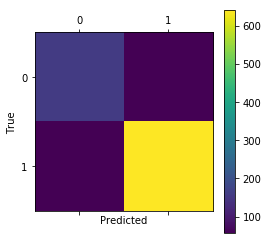

In [227]:
print_test_accuracy(show_confusion_matrix=True)

In [225]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_te2
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()